## How to predict heart disease through the age, sex, serum cholestoral, and resting electrocardiographic results.

## 1. Introduction
In this project, the dataset about heart disease from the UCI will be used which includes 14 attributes   
age-Age    
sex-Sex  
cp-chest pain type  
trestbps - Resting blood pressure  
chol - Serum cholestoral  
fbs - Fasting blood sugar  
restecg - Resting electrocardiographic results  
thalach - Maximum heart rate achieved  
exang - Exercise-induced angina  
oldpeak - ST depression induced by exercise relative to rest  
slope - The slope of the peak exercise ST segment   
ca - Number of major vessels (0-3) colored by flourosopy  
thal - 3 = normal; 6 = fixed defect; 7 = reversible defect  
num - For Heart Disease: Presence or Absence.  

## 2. Preliminary exploratory data analysis

**Install Packages**  

In [45]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(RColorBrewer)

**Read the data into the R, add column names for each column, and rename the num to make it more readability.** 

In [74]:
download.file("https://raw.githubusercontent.com/ZihanZhou0612/DSCI-100-002-Zihan-Zhou-Project/main/data/heart_disease/processed.cleveland.data",
              "data/processed_cleveland.csv")
data <- read_csv("data/processed_cleveland.csv", col_names = FALSE)|>
    rename(age = X1,
           sex = X2,
           cp = X3,
           trestbps = X4,
           chol = X5,
           fbs = X6,
           restecg = X7,
           thalach = X8,
           exang = X9,
           oldpeak = X10,
           slope = X11,
           ca = X12,
           thal = X13,
           num = X14) |>
    mutate(num = as_factor(num)) |>
    mutate(num = fct_recode(num, "A" = "0", "P" = "1", "P" = "2", "P" = "3", "P" = "4"))
data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,A
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,P
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,P
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,P
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,P
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,A


**Clean and wrangle the data into a tidy formats**  

This project aims to explore how to predict heart disease through the age, sex, serum cholestoral, and resting electrocardiographic results. Therefore, the tidy data should only includes 5 columns (age, sex, chol, restecg, and num). Due to the original data has some missing values, the first step is deleting those rows which includes missing data. Then, select these 5 columns to make the data into a tidy format.

In [3]:
tidy_data <- data |>
    filter (age != "?" & 
            sex	 != "?" & 
            chol != "?" & 
            restecg	 != "?" & 
            num != "?") |>
    select (age, sex, chol, restecg, num)
tidy_data

age,sex,chol,restecg,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,233,2,A
67,1,286,2,P
67,1,229,2,P
⋮,⋮,⋮,⋮,⋮
57,1,131,0,P
57,0,236,2,P
38,1,175,0,A


**Split the data to training dataset and testing dataset.**  

In [4]:
data_split <- initial_split(tidy_data, prop = 0.75, strata = num)  
data_train <- training(data_split)   
data_test <- testing(data_split)
data_train
data_test

age,sex,chol,restecg,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,233,2,A
37,1,250,0,A
57,0,354,0,A
⋮,⋮,⋮,⋮,⋮
45,1,264,0,P
68,1,193,0,P
57,1,131,0,P


age,sex,chol,restecg,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
41,0,204,2,A
56,1,236,0,A
62,0,268,2,P
⋮,⋮,⋮,⋮,⋮
55,0,342,0,A
63,0,197,0,P
57,0,236,2,P


**Summarize the training data in tables.**  

In [90]:
data_train |>
    summarize (
        total_observations = nrow(data_train),
        average_age = sum(age)/nrow(data_train))

total_observations,average_age
<int>,<dbl>
227,54.57269


In [88]:
data_train |>
  group_by(sex, num) |>
  summarize(
    percentage = n() / nrow(data_train) * 100)

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,percentage
<dbl>,<fct>,<dbl>
0,A,23.788546
0,P,7.488987
1,A,30.396476
1,P,38.325991


In [89]:
data_train |>
  group_by(restecg) |>
  summarize(
    count = n(),
    percentage = n() / nrow(data_train) * 100)

restecg,count,percentage
<dbl>,<int>,<dbl>
0,117,51.541850
1,3,1.321586
2,107,47.136564


**Visualize the training data** 

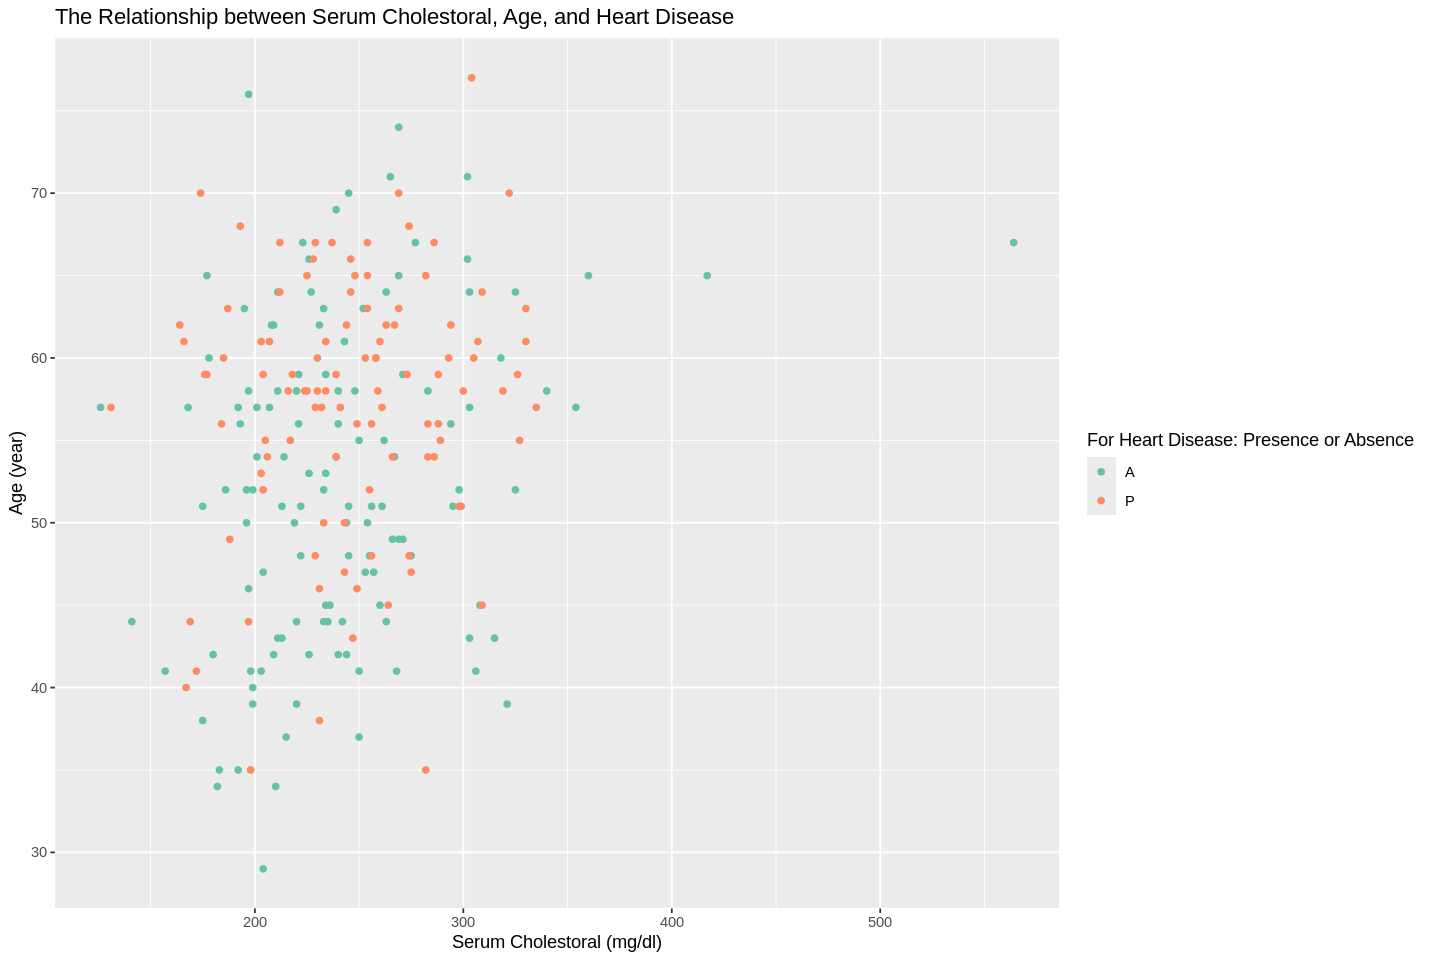

In [93]:
age_chol_heart <- data_train |>
    ggplot(aes(x = chol, y =  age)) + 
        geom_point(aes(colour = num)) + 
        labs (x = "Serum Cholestoral (mg/dl)", y = "Age (year)", colour = "For Heart Disease: Presence or Absence") + 
        ggtitle("The Relationship between Serum Cholestoral, Age, and Heart Disease") +
        scale_color_brewer(palette = "Set2") 
options(repr.plot.width = 12, repr.plot.height = 8)
age_chol_heart

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


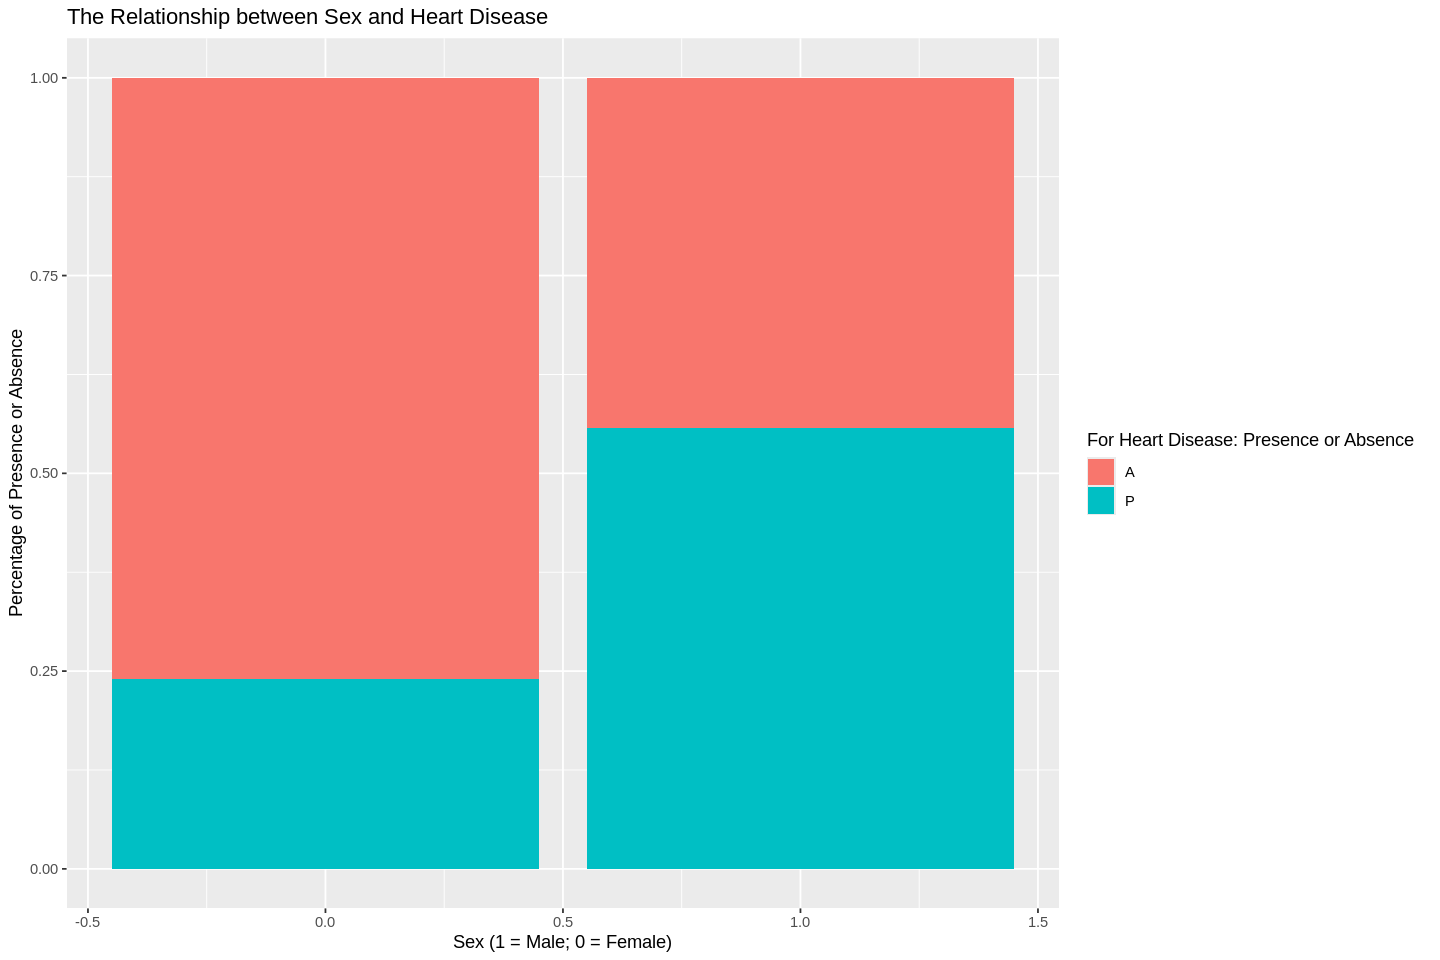

In [91]:
sex <- data_train |>
  group_by(sex, num) |>
  summarize(
    percentage = n() / nrow(data_train) * 100)
sex_count_plot <- ggplot(sex, aes(x = sex, y = percentage, fill = num)) + 
    geom_bar(stat = "identity", position = "fill") + 
    xlab("Sex (1 = Male; 0 = Female)") +
    ylab("Percentage of Presence or Absence") +
   labs(fill = "For Heart Disease: Presence or Absence") +
   ggtitle("The Relationship between Sex and Heart Disease") +
   scale_color_brewer(palette = "Set2") 
sex_count_plot

`summarise()` has grouped output by 'restecg'. You can override using the
`.groups` argument.


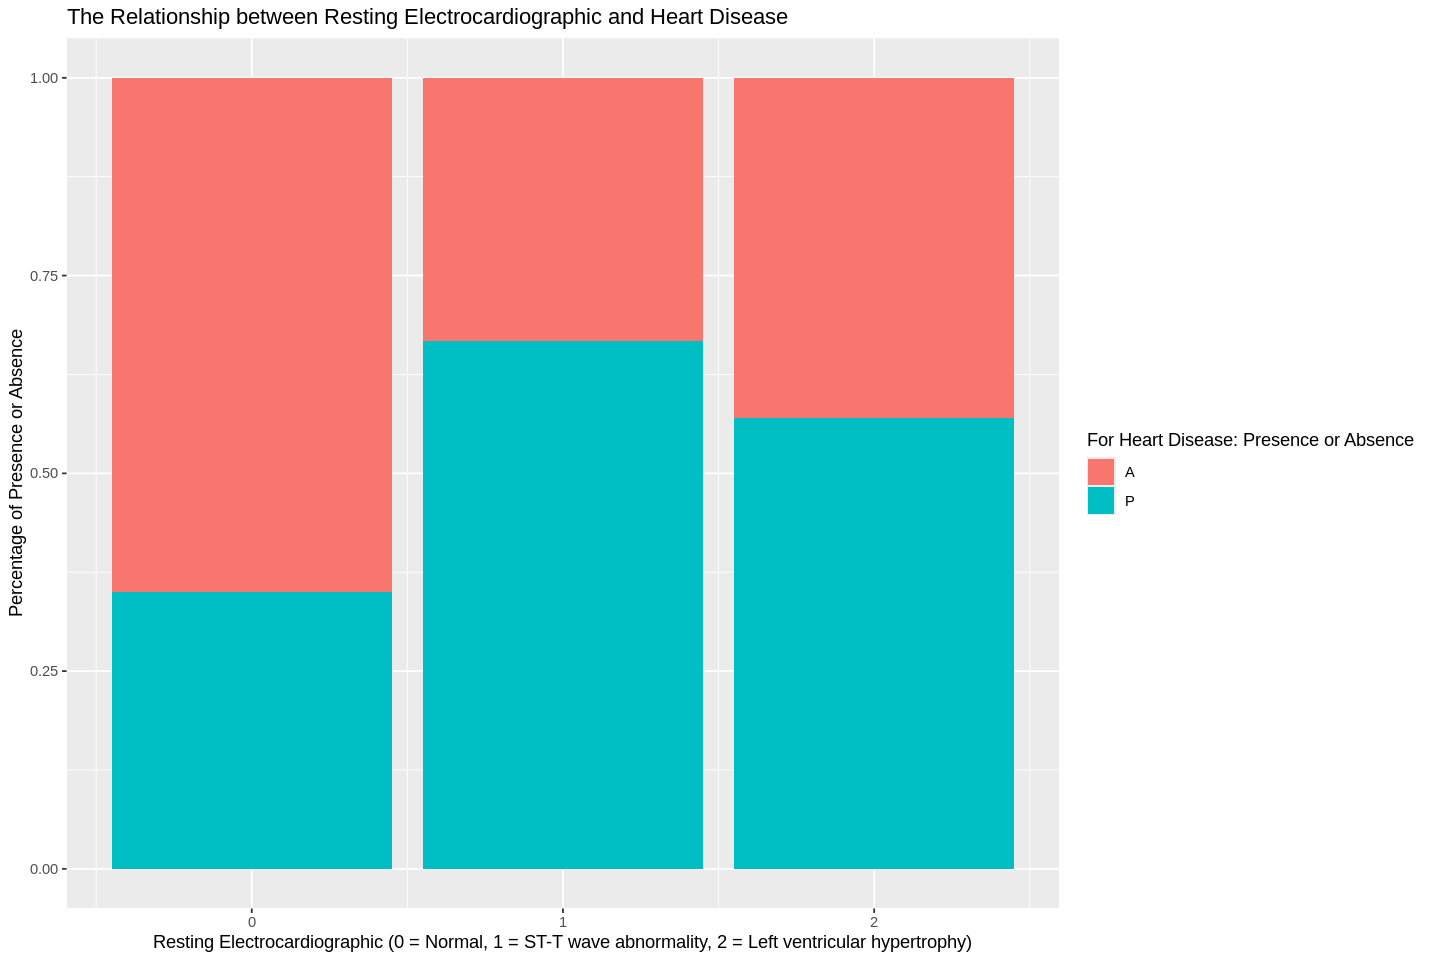

In [92]:
restecg <- data_train |>
  group_by(restecg, num) |>
  summarize(
    percentage = n() / nrow(data_train) * 100)
restecg_count_plot <- ggplot(restecg, aes(x = restecg, y = percentage, fill = num)) + 
    geom_bar(stat = "identity", position = "fill") + 
    xlab("Resting Electrocardiographic (0 = Normal, 1 = ST-T wave abnormality, 2 = Left ventricular hypertrophy)") +
    ylab("Percentage of Presence or Absence") +
   labs(fill = "For Heart Disease: Presence or Absence") +
   ggtitle("The Relationship between Resting Electrocardiographic and Heart Disease") +
   scale_color_brewer(palette = "Set2") 
restecg_count_plot

## 3. Methods

The next step of this project is standardizing the data before testing various K values to find the best K value. Then, using the training data and the best K value to create a fitted K-nearest neighbours model for this project. After that, the testing data will be used to test the fitted model and test how accurate the model is.

## 4. Expected outcomes and significance

This project is expected to find the relationship between age, sex, serum cholestoral, and resting electrocardiographic results, and find a fitted model that can use these four factors to predict whether this person has heart disease or not.  

This project not only can find a fitted model that can predict heart disease through these four factors, but it also shows people how these four factors impact the risk of having heart disease, which can alarm some groups of people to pay more attention to their heart health.